In [2]:
import pydrake
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import cv2
import os

from pydrake.solvers import MathematicalProgram, Solve
from pydrake.multibody.plant import MultibodyPlant
from pydrake.multibody.parsing import Parser
from pydrake.systems.framework import Context, LeafSystem
from pydrake.solvers.snopt import SnoptSolver
from pydrake.solvers.ipopt import IpoptSolver
from pydrake.solvers.osqp import OsqpSolver
from pydrake.solvers import CommonSolverOption, SolverOptions

%matplotlib inline

np.set_printoptions(precision=3, suppress=True)

sh: ffmpeg: command not found


([<matplotlib.axis.XTick at 0x289753790>,
 [Text(0, 0, '0.0'),
  Text(10, 0, '1.0'),
  Text(20, 0, '2.0'),
  Text(30, 0, '3.0'),
  Text(40, 0, '4.0')])

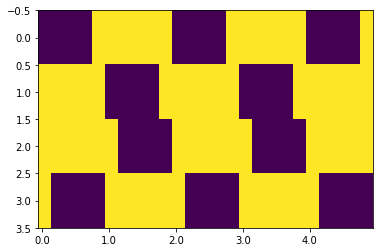

In [3]:
g = 9.81

def rotation_z_mat(psi_k):
    # returns the rotation matrix for a rotation about the z axis
    return np.array([[np.cos(psi_k), -np.sin(psi_k), 0],
                     [np.sin(psi_k), np.cos(psi_k), 0],
                     [0, 0, 1]])

def get_foot_positions(p_k, psi_k, l, v=0, v_cmd=0, omega_cmd=0, h=0.5, t_stance=2, k=0.03):
    """
    Foot step planner
    returns the foot positions for a given step k
    
    inputs:
    
    p_k - body position at step k, wrt world
    
    psi_k - body orientation at step k
    
    l - i_th leg shoulder location wrt body frame, (4,) array
        - convention: [FL, FR, BL, BR]
        
    v - body velocity at step k
    
    v_cmd - commanded body velocity
    
    omega_cmd - commanded body angular velocity
    
    t_stance - stance time
    
    k - velocity gain
    
    h - step height ????
    """
    positions = []
    p_symmetry = 0#t_stance * v / 2 + k * (v - v_cmd) 
    p_centrifugal = 0#0.5 * np.sqrt(h/g) * np.cross(v, omega_cmd)
    for i in range(4):
        # p_shoulder is the i-th shoulder location wrt global frame
        p_shoulder = p_k + rotation_z_mat(psi_k) @ l[i]
        p_shoulder[2] = 0
        positions.append(p_shoulder + p_symmetry + p_centrifugal)
        
    return positions

def gen_body_trajectory(v, omega, dt, N, z=0.5):
    """
    Generates a body trajectory for a given velocity and angular velocity
    
    input:
    
    v - x, y body velocity in body frame
    
    z - body height
    
    omega - body angular velocity, scalar
    
    dt - time step
    
    N - number of steps
    
    returns:
    Nx8 trajectory vector: (x, y, z, x_dot, y_dot, z_dot=0, psi, psi_dot=omega)
    """
    body_trajectory = np.zeros((N, 8))
    rot_mat = rotation_z_mat(omega * dt)
    v = np.append(v, 0)
    for i in range(N):
        if i > 0:
            body_trajectory[i, :3] = rot_mat @ (body_trajectory[i-1, :3] + v * dt)
        # convert body velocity to world frame
        body_trajectory[i, 3:6] = rot_mat @ v
        body_trajectory[i, 6] = i * omega * dt
        body_trajectory[i, 7] = omega
    
    body_trajectory[:, 2] = z
    return body_trajectory

def gen_foot_positions(body_traj, contact_sequence, leg_shoulder_pos):
    """
    Generate foot positions for a given body trajectory
    
    input:
    
    body_traj - Nx8 body trajectory
    
    contact_sequence - Nx4 contact sequence boolean array
    
    leg_shoulder_pos - i_th leg shoulder location wrt body frame, (4,) array
    
    returns:
    
    foot_positions - Nx4x3 foot position array
    """
    t = 0
    prev_contacts = np.zeros(4)
    foot_positions = np.zeros((N, 4, 3))

    for i in range(N-1):
        body_state = body_traj[i]
        contacts = contact_sequence[i]
        # get the indices where leg went from not in contact to in contact
        new_in_contact = np.where(np.logical_and(prev_contacts == 0, contacts == 1))[0]
        # get the indices where leg went from in contact to not in contact
        new_out_contact = np.where(np.logical_and(prev_contacts == 1, contacts == 0))[0]
        
        new_foot_positions = get_foot_positions(body_state[:3], 
                                            body_state[6], 
                                            leg_shoulder_pos)
        
        # foot_positions[i] is the prev foot position, unless it just went out of contact
        foot_positions[i] = foot_positions[i-1]
        for j in new_in_contact:
            foot_positions[i, j] = new_foot_positions[j]
        
        prev_contacts = contacts
        
    return foot_positions


class ContactScheduler:
    """
    Contact Scheduler assigns contact sequence for next N steps
    """
    def __init__(self, period, dt):
        self.period = period
        self.dt = dt
        self.phase = 0
        
    def make_trot_contact_sequence(self, N, t):
        """
        Makes a trot contact sequence for the next N steps, starting at time t
        
        inputs:
        
        N - number of steps
        t - current time
        
        output:
        
        contact_sequence - (N, 4) array, where each row is a contact sequence for a step
        """
        # trot_phase_offsets are the percentage offset where contact should start
        trot_phase_offsets = [0.6, 0.1, 0, 0.5]
        contact_sequence = np.zeros((N, 4))
        # t_stance is how long the robot spends in stance
        t_stance = 0.6 * self.period
        
        for i in range(N):
            time = t + i * self.dt
            for j in range(4):
                phase = (time + trot_phase_offsets[j] * self.period) % self.period
                if phase < t_stance:
                    contact_sequence[i, j] = 1
        return contact_sequence


leg_shoulder_pos = [np.array([0.5,0.5,0]),
    np.array([0.5,-0.5,0]),
    np.array([-0.5,0.5,0]),
    np.array([-0.5,-0.5,0])]

body_cmd_vel = np.array([0.5, 0])
omega = np.pi/200
dt = 0.1
N = 50
body_traj = gen_body_trajectory(body_cmd_vel, omega, dt, N)

contact_scheduler = ContactScheduler(2, dt)
contact_sequence = contact_scheduler.make_trot_contact_sequence(N, 0)

t = 0
prev_contacts = np.zeros(4)
foot_positions = np.zeros((N, 4, 3))

for i in range(N):
    body_state = body_traj[i]
    contacts = contact_sequence[i]
    # get the indices where leg went from not in contact to in contact
    new_in_contact = np.where(np.logical_and(prev_contacts == 0, contacts == 1))[0]
    # get the indices where leg went from in contact to not in contact
    new_out_contact = np.where(np.logical_and(prev_contacts == 1, contacts == 0))[0]
    
    new_foot_positions = get_foot_positions(body_state[:3], 
                                        body_state[6], 
                                        leg_shoulder_pos)
    
    # foot_positions[i] is the prev foot position, unless it just went out of contact
    foot_positions[i] = foot_positions[i-1]
    for j in new_in_contact:
        foot_positions[i, j] = new_foot_positions[j]
    
    prev_contacts = contacts
    
    fig = plt.figure()
    # plot x,y from body_traj
    plt.plot(body_traj[:, 0], body_traj[:, 1], '.')
    plt.axis('equal')
    
    # plot the x,y positions of foots,
    # FL should be red, FR should be green, BL should be blue, BR should be black
    colors = ['r', 'g', 'b', 'k']
    for j in range(4):
        if contacts[j]:
            plt.plot(foot_positions[i, j, 0], foot_positions[i, j, 1], 'o', color=colors[j])
            
    # draw the convex hull of foot positions in contact, if number of contacts > 2
    if np.sum(contacts) > 2:
        hull = ConvexHull(foot_positions[i, contacts == 1, :2])
        for simplex in hull.simplices:
            plt.plot(foot_positions[i, contacts == 1, 0][simplex], foot_positions[i, contacts == 1, 1][simplex], 'k-')
            
    # save figure to image
    fig.savefig('notebook_outputs/frame_{}.png'.format(i))    
    plt.close(fig)
    
os.system("ffmpeg -r {} -i notebook_outputs/frame_%d.png -vcodec mpeg4 -y movie.mp4".format(int(1/dt)))

plt.figure()
plt.imshow(contact_sequence.T, aspect='auto')
# make the x axis time
plt.xticks(np.arange(0, N, 10), np.arange(0, N*dt, 10*dt))

In [24]:
# MPC control class for quadruped

def skew(x):
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])

class QuadrupedMPC(LeafSystem):

    def __init__(self, N, dt, Q, R):
        """
        Model-Predictive Control for approximated quadruped
        
        Goal:
        Find reaction forces given pre-defined contacts and body trajectory
        """
        
        LeafSystem.__init__(self)
        """
        self.plant = MultibodyPlant(0.0)
        self.parser = Parser(self.plant)
        self.parser.AddModelFromFile("../models/xml/mini_cheetah.xml")
        self.plant.WeldFrames(self.plant.world_frame(), 
                              self.plant.GetFrameByName("body"))
        self.plant.Finalize()
        self.plant_context = self.plant.CreateDefaultContext()
        """
        self.N = N
        self.dt = dt

        # inertia tensor of the body
        # approximated as a rectangular prism with dimensions w, l, h
        self.I_B = np.diag([0.042673, 0.036203, 0.011253])
        
        # mass of the body
        self.m = 8.852
        
        self.g = np.zeros((12,))
        self.g[9:] = np.array([0, 0, -self.m*9.81])
        
        self.Q = Q
        self.R = R

    def discrete_time_dynamics(self, x_ref_k, r_k):
        """
        Returns A_k, B_k simplified discrete time dynamics for quadruped
        
        x_ref_k is the reference state of the body:
        [Theta, p, omega, p_dot] 
        
        Theta [phi, theta, psi] - roll, pitch, yaw of the body in world frame
        p [x, y, z] - the position of the body in the world frame
        omega - angular velocity of the body in local frame
        p_dot - velocity of the body in world frame
        shape is (12,1)
        
        r_k - positions of contact points relative to the body
        shape is (num_contacts, 3)
        
        """
        I3 = np.eye(3)
        Z3 = np.zeros((3, 3))
        
        psi_k = x_ref_k[2]
        Rz_k = rotation_z_mat(psi_k)
        A_k = np.zeros((12, 12))
        A_k[:3, :] = np.hstack((I3, Z3, Rz_k * self.dt, Z3))
        A_k[3:6, :] = np.hstack((Z3, I3, Z3, I3 * self.dt))
        A_k[6:9, :] = np.hstack((Z3, Z3, I3, Z3))
        A_k[9:, :] = np.hstack((Z3, Z3, Z3, I3))
        
        I_G = Rz_k @ self.I_B @ Rz_k.T
        B_k = np.zeros((12, 3 * r_k.shape[0]))
        
        for i in range(r_k.shape[0]):
            B_k[6:9, 3 * i:3 * (i + 1)] = np.linalg.inv(I_G) @ skew(r_k[i, :]) * self.dt
            B_k[9:, 3 * i:3 * (i + 1)] = I3 * self.dt / self.m
        
        return A_k, B_k
        
    def add_initial_constraints(self, x, x_ref):
        """
        Add initial constraints to the program
        
        inputs:
        
        x - (N, 12) array of body states
        
        x_ref - (N, 12) array of reference body states
        """
        init_constraint = self.prog.AddLinearEqualityConstraint(x[0, :], x_ref[0, :])
        init_constraint.evaluator().set_description("initial constraint")
        
    def add_final_constraints(self, x, x_ref):
        """
        Add final constraints to the program
        
        inputs:
        
        x - (N, 12) array of body states
        
        x_ref - (N, 12) array of reference body states
        """
        final_constraint = self.prog.AddLinearEqualityConstraint(x[-1, :], x_ref[-1, :])
        final_constraint.evaluator().set_description("final constraint")
        
    def get_fk(self, indices, f):
        """ 
        Get reaction force decision vars that have contacts
        
        inputs: 
        
        indices - list of indices for contact forces
        
        f - (12,) array of reaction forces for current time step
        
        example:
        
        f = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
        indices = [0, 2]
        f_k = np.array([1, 2, 3, 7, 8, 9])
        
        output:
        
        f_k - (3*num_contacts,1) array of reaction forces for current time step
        """
        f_k = np.zeros((len(indices)*3, 1), dtype="object")
        for i, idx in enumerate(indices):
            f_k[3*i:3*(i+1), :] = f[3*idx:3*(idx+1)].reshape(3,1)
            
        return f_k
    
    def add_dynamic_constraints(self, x, f, x_ref, r_ref, fsm):
        """
        Add dynamic constraints to the program
        
        inputs:
        
        x - (N, 12) array of body states
        
        f - (N-1, 3*4) array of contact forces
        
        x_ref - (N, 12) array of reference body states
        
        r_ref - (N-1, 4, 3) array of reference foot positions
        
        fsm - (N-1, 4) array of contact sequences
        
        for each time step in the horizon,
            we need to identify which legs are in contact
            then fix dynamics
        
        """
        
        for i in range(self.N - 1):
            in_contact = np.where(fsm[i, :] == 1)[0]
            r_k = r_ref[i, in_contact, :]
            f_k = self.get_fk(in_contact, f[i, :]).flatten()
            x_k = x[i, :]
            x_kp1 = x[i + 1, :]

            A_k, B_k = self.discrete_time_dynamics(x_ref[i, :], r_k)
            dyn = A_k @ x_k + B_k @ f_k + self.g - x_kp1
            
            dyn_constraint = self.prog.AddLinearEqualityConstraint(dyn, np.zeros((12,)))
            dyn_constraint.evaluator().set_description("dynamics constraint")
    
    def add_contact_constraints(self, f, fsm, mu=0.7):
        """
        Add ground reaction force constraints to the program
        
        inputs:
        
        f - (N-1, 3*4) array of contact forces
        
        fsm - (N-1, 4) array of contact sequences
        
        for each foot in contact,
            abs(fx) <= mu * fz
            abs(fy) <= mu * fz
            fz >= 0
            
        else, fix to zero
        
        """
        
        for i in range(self.N-1):
            
            
            in_contact = np.where(fsm[i, :] == 1)[0]
            not_in_contact = np.where(fsm[i, :] == 0)[0]
            f_k = self.get_fk(in_contact, f[i, :])
            f_k_not = self.get_fk(not_in_contact, f[i, :])

            num_contacts = len(in_contact)
            epsilon = 2e-3
            
            for j in range(num_contacts):
                A = np.array( [[1, 0, -mu], 
                               [-1, 0, -mu], 
                               [0, 1, -mu], 
                               [0, -1, -mu], 
                               [0, 0, -1]])
                f_k_j = f_k[3 * j:3 * (j + 1)]
                ub = np.array([0, 0, 0, 0, 0])
                lb = np.array([-np.inf, -np.inf, -np.inf, -np.inf, -3000])
                f_contact = self.prog.AddLinearConstraint(A@f_k_j,lb,ub)
                f_contact.evaluator().set_description("font contact constraint j={}".format(j))
                
    def add_cost(self, x, x_ref, f):
        """
        Add cost to the program
        
        inputs:
        
        x - (N, 12) array of body states
        
        x_ref - (N, 12) array of reference body states
        
        f - (N-1, 3*4) array of contact forces
        """
        for i in range(self.N-1):
            x_kp1 = x[i+1, :]
            x_ref_kp1 = x_ref[i+1, :]
            x_dk = x_kp1 - x_ref_kp1
            self.prog.AddQuadraticCost(x_dk.T @ self.Q @ x_dk)
            f_k = f[i, :]
            self.prog.AddQuadraticCost(f_k.T @ self.R @ f_k)
            
    def compute_mpc(self, x_ref, r_ref, fsm):
        """
        Compute the optimal control input
        
        inputs:
        
        x_ref - (N, 12) array of reference body states
        
        r_ref - (N-1, 4, 3) array of reference foot positions
        
        fsm - (N-1, 4) array of contact sequences
        
        returns:
        
        u - (N, 3*4) array of contact forces
        """
        print("Computing MPC...")
        self.prog = MathematicalProgram()
        x = np.zeros((self.N, 12), dtype="object")
        for i in range(N):
            x[i] = self.prog.NewContinuousVariables(12, "x_" + str(i))
        f = np.zeros((self.N-1, 3*4), dtype="object")
        for i in range(N-1):
            in_contact = np.where(fsm[i, :] == 1)[0] # TODO: eliminate decision variables for feet not in contact
            for idx in in_contact:
                f[i, 3 * idx:3 * (idx + 1)] = self.prog.NewContinuousVariables(3, "f_" + str(i) + "_" + str(idx))
        
        print("Adding initial condition constraint...")
        self.add_initial_constraints(x, x_ref)
        print("Adding final condition constraint...")
        self.add_final_constraints(x, x_ref)
        print("Adding dynamic constraints...")
        self.add_dynamic_constraints(x, f, x_ref, r_ref, fsm)
        print("Adding contact constraints...")
        self.add_contact_constraints(f, fsm)
        
        self.add_cost(x, x_ref, f)
        
        print("Solving...")
        solver = OsqpSolver()
        logfile = "logs/debug.txt"
        # if logfile exists, delete it
        if os.path.exists(logfile):
            os.remove(logfile)
        solver_options = SolverOptions()
        solver_options.SetOption(CommonSolverOption.kPrintFileName, logfile)
        result = solver.Solve(self.prog, solver_options=solver_options)
        infeasible_constraints = result.GetInfeasibleConstraints(self.prog)

        for c in infeasible_constraints:
            print(f"infeasiable: {c}")
            
        #with open(logfile, "r") as f:
        #    print(f.read())
        
        if result.is_success():
            print("Success!")
            print(result.GetSolution(f))
            return (result.GetSolution(f), result.GetSolution(x))
        else:
            print("MPC failed to solve")
            return None
            
            

In [25]:
leg_shoulder_pos = [np.array([0.5,0.5,0]),
    np.array([0.5,-0.5,0]),
    np.array([-0.5,0.5,0]),
    np.array([-0.5,-0.5,0])]

body_cmd_vel = np.array([0.1, 0])
omega = np.pi/200
dt = 0.1
N = 20
x_ref = np.zeros((N, 12))
x_ref_tmp = gen_body_trajectory(body_cmd_vel, omega, dt, N)
x_ref[:,:2] = np.zeros((N,2))
x_ref[:,2] = x_ref_tmp[:,6]
x_ref[:,3:6] = x_ref_tmp[:,:3]
x_ref[:,6:8] = np.zeros((N,2))
x_ref[:,8] = x_ref_tmp[:,7]
x_ref[:,9:12] = x_ref_tmp[:,3:6]

contact_scheduler = ContactScheduler(2, dt)
fsm = contact_scheduler.make_trot_contact_sequence(N, 0)
r_ref = gen_foot_positions(x_ref_tmp, fsm, leg_shoulder_pos)
# convert r_ref from world frame to body frame
r_ref = r_ref - x_ref[:, np.newaxis, 3:6]

In [26]:
Q = np.diag([1000, 1000, 1, 1, 1, 1000, 1000, 1000, 1, 1, 1, 1000000])
R = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
mpc = QuadrupedMPC(N, dt, Q, R)
f_mpc, x_mpc = mpc.compute_mpc(x_ref, r_ref[:N-1], fsm[:N-1])
f_mpc = np.vectorize(lambda x: x.Evaluate())(f_mpc)

plt.figure(figsize=(30,N/2))
plt.imshow(f_mpc.T)
# save plot as image named "gait_force.png"
plt.savefig("../gait_force.png")

Computing MPC...
Adding initial condition constraint...
Adding final condition constraint...
Adding dynamic constraints...
Adding contact constraints...
Solving...
infeasiable: LinearConstraint described as 'font contact constraint j=0'
-inf <= (f_0_1(0) - 0.69999999999999996 * f_0_1(2)) <= 0
-inf <= ( - f_0_1(0) - 0.69999999999999996 * f_0_1(2)) <= 0
-inf <= (f_0_1(1) - 0.69999999999999996 * f_0_1(2)) <= 0
-inf <= ( - f_0_1(1) - 0.69999999999999996 * f_0_1(2)) <= 0
-3000 <= (-1 * f_0_1(2)) <= 0

infeasiable: LinearConstraint described as 'font contact constraint j=1'
-inf <= (f_0_2(0) - 0.69999999999999996 * f_0_2(2)) <= 0
-inf <= ( - f_0_2(0) - 0.69999999999999996 * f_0_2(2)) <= 0
-inf <= (f_0_2(1) - 0.69999999999999996 * f_0_2(2)) <= 0
-inf <= ( - f_0_2(1) - 0.69999999999999996 * f_0_2(2)) <= 0
-3000 <= (-1 * f_0_2(2)) <= 0

infeasiable: LinearConstraint described as 'font contact constraint j=2'
-inf <= (f_0_3(0) - 0.69999999999999996 * f_0_3(2)) <= 0
-inf <= ( - f_0_3(0) - 0.69999

TypeError: cannot unpack non-iterable NoneType object

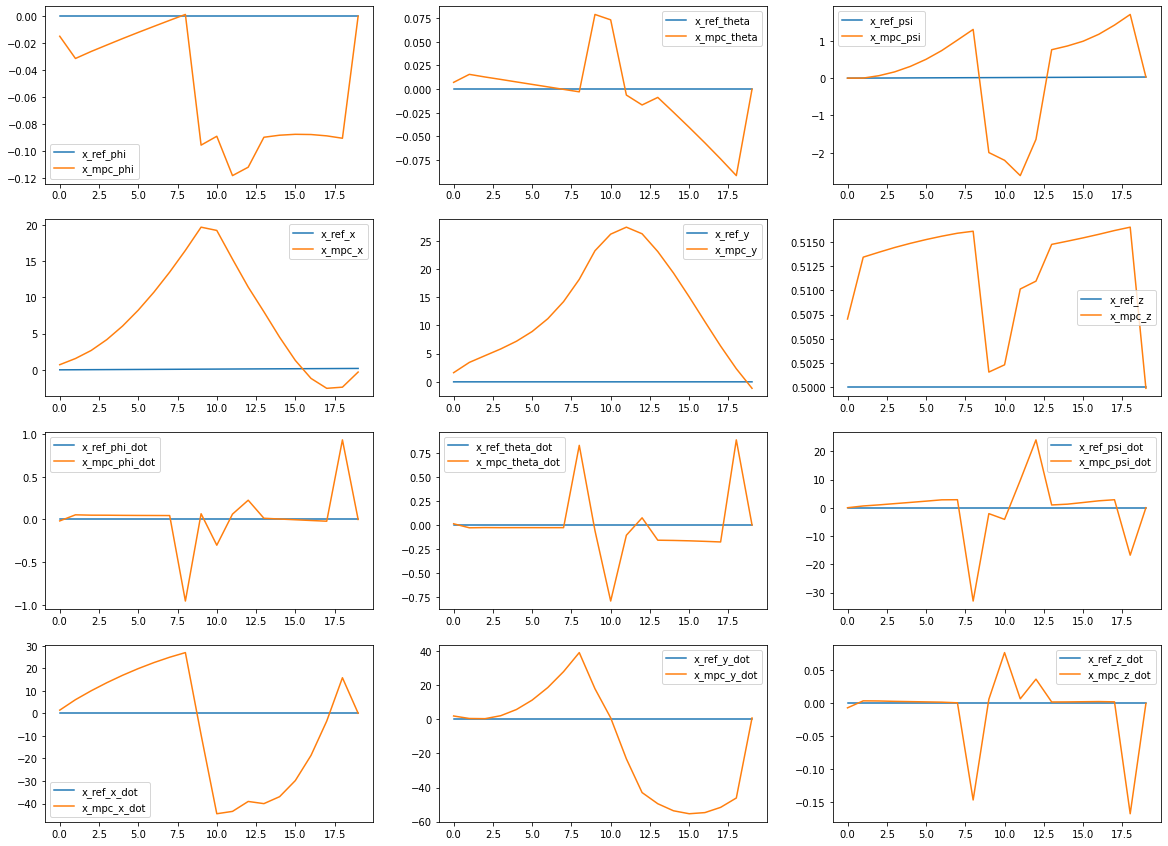

In [22]:
def plot_com_traj(x_ref, x_mpc):
    """
    Plots the center of mass trajectory for the reference and the MPC solution
    
    input:
    
    x_ref - (N, 12) array of reference body states
    
    x_mpc - (N, 12) array of MPC body states
    
    
    x is organized as: [phi, theta, psi, x, y, z, phi_dot, theta_dot, psi_dot, x_dot, y_dot, z_dot]
    
    """
    
    plt.figure(figsize=(20,15))
    plt.subplot(4,3,1)
    plt.plot(x_ref[:,0], label="x_ref_phi")
    plt.plot(x_mpc[:,0], label="x_mpc_phi")
    plt.legend()
    plt.subplot(4,3,2)
    plt.plot(x_ref[:,1], label="x_ref_theta")
    plt.plot(x_mpc[:,1], label="x_mpc_theta")
    plt.legend()
    plt.subplot(4,3,3)
    plt.plot(x_ref[:,2], label="x_ref_psi")
    plt.plot(x_mpc[:,2], label="x_mpc_psi")
    plt.legend()
    plt.subplot(4,3,4)
    plt.plot(x_ref[:,3], label="x_ref_x")
    plt.plot(x_mpc[:,3], label="x_mpc_x")
    plt.legend()
    plt.subplot(4,3,5)
    plt.plot(x_ref[:,4], label="x_ref_y")
    plt.plot(x_mpc[:,4], label="x_mpc_y")
    plt.legend()
    plt.subplot(4,3,6)
    plt.plot(x_ref[:,5], label="x_ref_z")
    plt.plot(x_mpc[:,5], label="x_mpc_z")
    plt.legend()
    plt.subplot(4,3,7)
    plt.plot(x_ref[:,6], label="x_ref_phi_dot")
    plt.plot(x_mpc[:,6], label="x_mpc_phi_dot")
    plt.legend()
    plt.subplot(4,3,8)
    plt.plot(x_ref[:,7], label="x_ref_theta_dot")
    plt.plot(x_mpc[:,7], label="x_mpc_theta_dot")
    plt.legend()
    plt.subplot(4,3,9)
    plt.plot(x_ref[:,8], label="x_ref_psi_dot")
    plt.plot(x_mpc[:,8], label="x_mpc_psi_dot")
    plt.legend()
    plt.subplot(4,3,10)
    plt.plot(x_ref[:,9], label="x_ref_x_dot")
    plt.plot(x_mpc[:,9], label="x_mpc_x_dot")
    plt.legend()
    plt.subplot(4,3,11)
    plt.plot(x_ref[:,10], label="x_ref_y_dot")
    plt.plot(x_mpc[:,10], label="x_mpc_y_dot")
    plt.legend()
    plt.subplot(4,3,12)
    plt.plot(x_ref[:,11], label="x_ref_z_dot")
    plt.plot(x_mpc[:,11], label="x_mpc_z_dot")
    plt.legend()
    plt.show()

    
plot_com_traj(x_ref[:], x_mpc[:])

In [23]:
f_mpc[:20]

array([[    0.   ,     0.   ,     0.   ,   148.911,  -144.245,  3695.682,
          148.553,  -144.603,  3988.567,    -0.29 ,     0.286,     4.248],
       [    0.   ,     0.   ,     0.   ,   136.371,   -56.368,  3783.629,
          137.24 ,   -55.538,  3899.411,    -0.23 ,     0.226,     3.854],
       [    0.   ,     0.   ,     0.   ,   123.843,    31.54 ,  3873.955,
          122.591,    30.244,  3812.905,     0.   ,     0.   ,     0.   ],
       [    0.   ,     0.   ,     0.   ,   115.287,   123.257,  3962.353,
          108.101,   116.031,  3724.522,     0.   ,     0.   ,     0.   ],
       [    0.   ,     0.   ,     0.   ,   108.636,   216.741,  4050.616,
           91.96 ,   200.038,  3636.259,     0.   ,     0.   ,     0.   ],
       [    0.   ,     0.   ,     0.   ,   103.913,   311.964,  4138.725,
           74.197,   282.239,  3548.15 ,     0.   ,     0.   ,     0.   ],
       [    0.   ,     0.   ,     0.   ,   101.113,   408.872,  4226.627,
           54.865,   362.634,  3